# Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import gan_protein_structural_requirements.utils as utils
from gan_protein_structural_requirements.utils.protein_visualizer import jupy_viz_obj as jvo, jupy_viz_file as jvf
from gan_protein_structural_requirements.utils.folding_models import esm_batch_predict as esm_batch_predict, esm_predict as esm_predict, load_tokenizer as load_tokenizer
from gan_protein_structural_requirements.utils.extract_structure import extract_structures as extract_structures, untokenize as untokenize, get_untokenizer as get_untokenizer
from gan_protein_structural_requirements.data import class_ccc_progan_dataset as cdt
import gan_protein_structural_requirements.utils.folding_models as fold
from gan_protein_structural_requirements.models import networks

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

# Data Analysis

### Load Dataset

In [4]:
dtst = cdt.Protein_dataset(
    root_dir="/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/data/raw/train",
    min_prot_len=200,
    max_prot_len=1024
    )

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: no atoms read before TER record 
TER    8879      TYR F1006                                                      
no atoms read before TER record 
TER    8947      TYR H1006                                                      
no atoms read before TER record 
TER    9015      TYR J1006                                                      
no atoms read before TER record 
TER    9083      TYR L1006                                                      

  warnings.warn(err)
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
empty protein, or no val

### Get Pandas DataFrame

In [9]:
data = {"alpha helix":[],"isolated beta-bridge residue":[],"strand":[],"3-10 helix":[],"pi helix":[],"turn":[],"bend":[],"none":[],"polarity proportion":[],"sequence":[]}
for entry in dtst.X[:,0]:
    entry = entry.tolist()
    data["alpha helix"].append(entry[0])
    data["isolated beta-bridge residue"].append(entry[1])
    data["strand"].append(entry[2])
    data["3-10 helix"].append(entry[3])
    data["pi helix"].append(entry[4])
    data["turn"].append(entry[5])
    data["bend"].append(entry[6])
    data["none"].append(entry[7])
    data["polarity proportion"].append(entry[8])
for entry in dtst.Y:
    data["sequence"].append(entry.tolist())

raw_data = pd.DataFrame(data)

### Get Density Curves of Features

array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>], dtype=object)

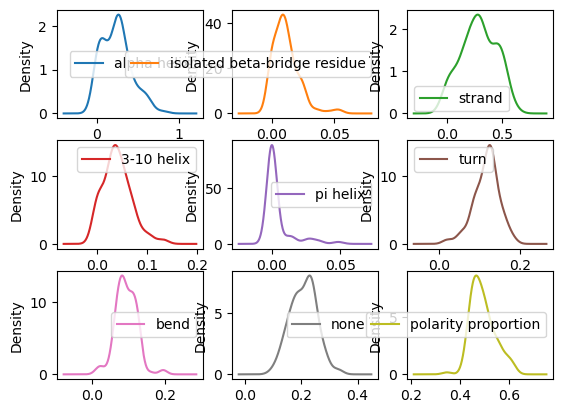

In [10]:
raw_features = raw_data.drop(columns=["sequence"])
fig, axes = plt.subplots(nrows=3, ncols=3)
raw_features.plot.kde(subplots=True, ax=axes)

Make a CCC-Progan Model and Train

In [26]:
#hyper param definition

latent_dim = 200
objective_dim = 9
hidden_dim = 256
num_rnn_layers = 3
sequence_dim = 21
batch_size = 32
max_prot_len = 1024
embed_size = 32
temperature = 1

#load in models
g = networks.RNN_generator(latent_dim,objective_dim,hidden_dim,num_rnn_layers,sequence_dim)
d = networks.Discriminator(batch_size, max_prot_len, [64,32],objective_dim,sequence_dim,embed_size)
f = networks.SeqToVecEnsemble(sequence_dim)

latent_input = torch.randn(batch_size,max_prot_len,latent_dim)
softmax = nn.Softmax(-1)

In [37]:
data = DataLoader(dtst,batch_size)
from gan_protein_structural_requirements.models.seqtovec_model import SeqToVecModel
net = SeqToVecModel(sequence_dim,0.02,0.05)